# Random Forest

In [1]:
#!pip install imblearn

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import RandomOverSampler, SMOTE

from src import ensemble_utils

## UDF

## Import Data

In [2]:
accidents = pd.read_csv('data/accidents.csv', index_col=0)
for idx, feature in enumerate(accidents.columns):
    print('{}. {}'.format(idx, feature))

0. RD_NO
1. CRASH_DATE
2. POSTED_SPEED_LIMIT
3. TRAFFIC_CONTROL_DEVICE
4. DEVICE_CONDITION
5. WEATHER_CONDITION
6. LIGHTING_CONDITION
7. FIRST_CRASH_TYPE
8. TRAFFICWAY_TYPE
9. LANE_CNT
10. ALIGNMENT
11. ROADWAY_SURFACE_COND
12. ROAD_DEFECT
13. CRASH_TYPE
14. INTERSECTION_RELATED_I
15. NOT_RIGHT_OF_WAY_I
16. HIT_AND_RUN_I
17. PRIM_CONTRIBUTORY_CAUSE
18. SEC_CONTRIBUTORY_CAUSE
19. STREET_NO
20. STREET_DIRECTION
21. STREET_NAME
22. BEAT_OF_OCCURRENCE
23. WORK_ZONE_I
24. WORK_ZONE_TYPE
25. WORKERS_PRESENT_I
26. INJURIES_UNKNOWN
27. CRASH_HOUR
28. CRASH_DAY_OF_WEEK
29. CRASH_MONTH
30. LATITUDE
31. LONGITUDE
32. LOCATION
33. crash_date
34. crash_year
35. crash_month
36. is_fatal_or_incap
37. time_of_day
38. is_weekend
39. season
40. is_cyclist
41. is_pedestrian
42. is_head_on
43. is_parked
44. is_using_cellphone
45. has_disregarded_traffic_devices
46. is_failed_to_yield_right_of_way
47. is_reckless_driving
48. is_sleet_snow
49. is_rain
50. is_clear_weather
51. has_snow_ice
52. is_dark_no_lig

## Select Features and Process Data 

In [3]:
indices = [2, 38, 40, 41, 42, 43, 48, 50, 53, 56, 57, 60, 64, 65]
selected_features = list(accidents.columns[indices])

X = accidents[selected_features]
y = accidents['is_fatal_or_incap']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=3)

In [4]:
oversampler = RandomOverSampler(sampling_strategy=0.75, random_state=3)
#oversampler = SMOTE(sampling_strategy=0.75, random_state=3)

X_over, y_over = oversampler.fit_resample(X_train.to_numpy(), y_train.to_numpy())

## Hyperparameter Tuning

In [21]:
n_features = X.shape[1]

n_estimators = [10, 50, 100]
max_features = [2, int(np.sqrt(n_features)), n_features // 2, n_features]
max_depth = [1, 2, 3]
params_grid = dict(n_estimators=n_estimators,
                   max_features=max_features,
                   max_depth=max_depth)

In [22]:
rf = RandomForestClassifier(random_state=3)

clf = GridSearchCV(rf, params_grid, cv=5, verbose=0, scoring='recall')

best_model = clf.fit(X_over, y_over)

In [23]:
print('Optimal # of Estimators: ', best_model.best_estimator_.get_params()['n_estimators'])
print('Optimal # of Features per Node: ', best_model.best_estimator_.get_params()['max_features'])
print('Max. Depth of Tree: ', best_model.best_estimator_.get_params()['max_depth'])

Optimal # of Estimators:  10
Optimal # of Features per Node:  3
Max. Depth of Tree:  3


### Train and Predict

In [5]:
n_estimators = 10
max_features = 3
max_depth = 3

rf = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, random_state=3)
rf.fit(X_over, y_over)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]


cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
print('\n')
print('Recall (Scores FN): ', round(recall_score(y_test, y_pred), 4))
print('Precision (Scores FP): ', round(precision_score(y_test, y_pred), 4))
print('AUC Score: ', round(roc_auc_score(y_test, y_prob), 4))

[[55270  2280]
 [  703   362]]


Recall (Scores FN):  0.3399
Precision (Scores FP):  0.137
AUC Score:  0.7346


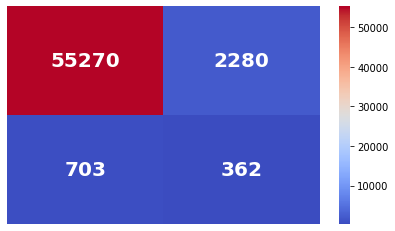

In [6]:
plt.figure(figsize=(7,4))
sns.heatmap(cf_matrix, cmap='coolwarm', annot=True, annot_kws={'size': 20, 'fontweight':'bold'}, fmt='d',
                 xticklabels=False, yticklabels=False);
#plt.savefig('img/cf_matrix.png', bbox_inches='tight')

### Permutation Importance

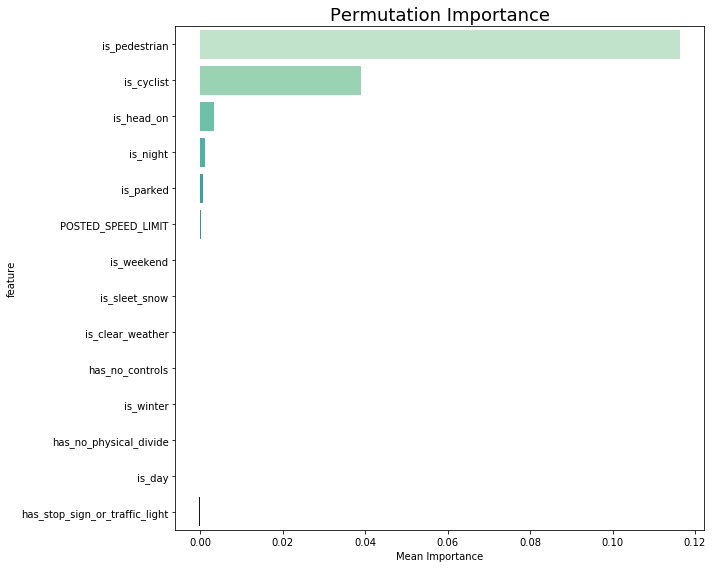

In [15]:
ensemble_utils.calculate_and_plot_permutation_importance(rf, X_over, y_over, 20, 3, (10,8), 16, X_train.columns)

In [25]:
def create_sorted_permutation_importance_df(model, X, y, n_iterations, random_state, features):
    '''
    Inputs:
    Enter a fitted tree-based model, e.g. Random Forest or Gradient Boost.
    X and y can be the training set or a hold-out set, i.e., validation or test.
    X and y must be dataframes.
    
    Return:
    Returns a sorted dataframe comprised of each feature's importance for the number of selected iterations.
    The dataframe is sorted by the features' medians.
    '''
    
    results = permutation_importance(model, X, y, n_repeats=n_iterations,
                                     random_state=random_state, n_jobs=-1)
    
    df = pd.DataFrame()
    df['feature'] = features
    df['mean_importance'] = results['importances_mean']
    df['std_importance'] = results['importances_std']
    df.sort_values(by='mean_importance', axis=0, ascending=False, inplace=True)
    return df

def plot_horizontal_permutation_importance_boxplot(df, figsize, max_features):
    '''
    df must be sorted.
    max_features is a limit on the number of features displayed
    '''
    
    df2 = df.iloc[2:, :].copy()
    
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.barplot(data=df2, x='mean_importance', y='feature', ax=ax, palette='mako_r')
    ax.set_xlabel('Mean Importance')
    ax.set_title('Permutation Importance', fontsize=18)
    fig.tight_layout();
    fig.savefig('img/perm_import_sub.png')


def calculate_and_plot_permutation_importance(model, X, y, n_iterations, random_state, figsize, max_features, features):
    '''
    Inputs:
    Enter a fitted tree-based model, e.g. Random Forest or Gradient Boost.
    X and y can be the training set or a hold-out set, i.e., validation or test.
    X and y must be dataframes.
    max_features is the number of features to be displayed on the boxplot.
    
    Returns a horizontal box plot summarizing each feature's permutation importance.
    '''
    sorted_df = create_sorted_permutation_importance_df(model, X, y, n_iterations, random_state, features)
    plot_horizontal_permutation_importance_boxplot(sorted_df, figsize, max_features)

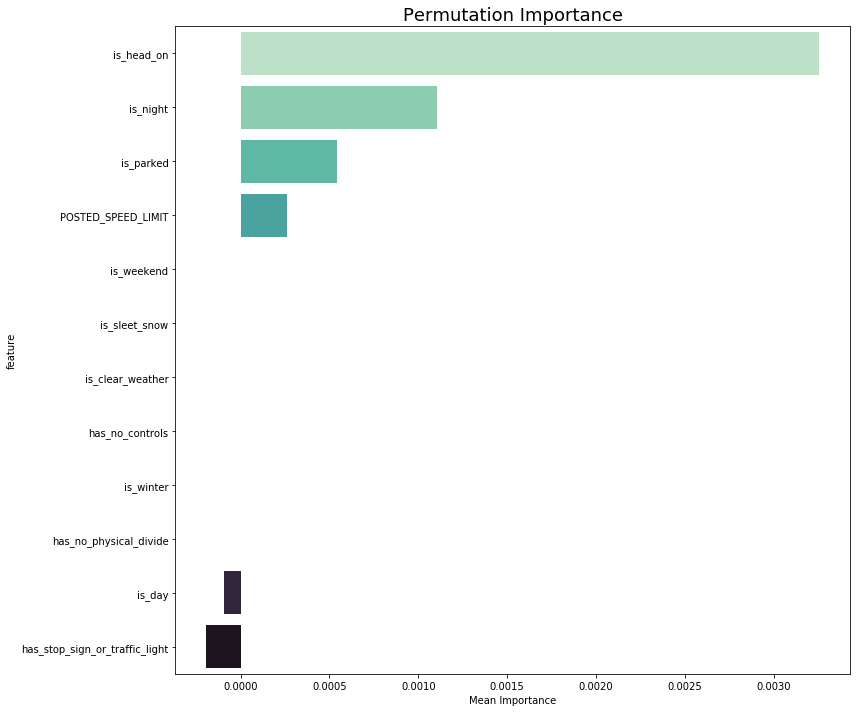

In [26]:
calculate_and_plot_permutation_importance(rf, X_over, y_over, 20, 3, (12,10), 16, X_train.columns)

In [16]:
df2

NameError: name 'df2' is not defined